This notebook will make an animated visualization of the solar system using positions calculated by `astropy` ephemeris functions.  Basically, it needs a standard Anaconda install, plus 

`conda install opencv`

to get the `cv2` package for making movies from stills.

In [1]:
import numpy as np
import pylab as plt
from astropy import units as u
from astropy import constants as c
from astropy.time import Time
from astropy.coordinates import get_body
import cv2
from glob import glob
import sys
sys.path.append('../.')
from ja import Timer, progress_bar as ProgressBar

In [4]:
# Times
time_interval = 11 * 365 * u.day  # 11 years
halfyear = np.arange(182)
oneyear = np.arange(365)
twoyear = np.arange(365*2)
t0 = Time('2020-06-22 12:00:00')
dt_approx = 1*u.day
nsteps = int((time_interval/dt_approx).to(u.dimensionless_unscaled).value)
time_steps, dt = np.linspace(0,time_interval.value,num=nsteps, retstep=True)
time_steps = time_steps*u.day
dt = dt*u.day
times = t0 + time_steps

In [5]:
def BodyPolarCoords(body, times):
    """ Given a solar system body name and desired times, calculates geocentric and
    heliocentric polar coordinates in the ecliptic plane """
    body_ephem = get_body(body, times)
    r_geo = body_ephem.geocentricmeanecliptic.distance.to(u.AU)
    theta_geo = body_ephem.geocentricmeanecliptic.lon
    r_hel = body_ephem.barycentrictrueecliptic.distance.to(u.AU)
    theta_hel = body_ephem.barycentrictrueecliptic.lon
    return {'r_geo': r_geo, 'theta_geo': theta_geo, 
            'r_hel': r_hel, 'theta_hel': theta_hel,
            'ephem':body_ephem}

In [6]:
body_names = ['moon','sun','mercury','venus','earth','mars','jupiter']
body_colors = ['green','yellow','cyan','magenta','blue','red','brown']

In [7]:
%%time
coords = {}

for color, name in zip(body_colors, body_names):
    coords[name] = BodyPolarCoords(name, times)  
    coords[name]['color'] = color

CPU times: user 18.9 s, sys: 35.1 ms, total: 18.9 s
Wall time: 19 s


In [9]:
coords['mars']

{'r_geo': <Distance [0.87012149, 0.86389523, 0.85769236, ..., 0.65807403, 0.66291886,
            0.66782767] AU>,
 'theta_geo': <Longitude [356.2926657 , 356.91368812, 357.53196829, ..., 214.15878724,
             214.2310365 , 214.31603896] deg>,
 'r_hel': <Distance [1.38514067, 1.38456726, 1.38400754, ..., 1.50926192, 1.50793573,
            1.50660964] AU>,
 'theta_hel': <Longitude [309.68151019, 310.3093328 , 310.93767367, ..., 246.33300937,
             246.8646962 , 247.39731471] deg>,
 'ephem': <SkyCoord (GCRS: obstime=['2020-06-22 12:00:00.000' '2020-06-23 12:00:21.525'
  '2020-06-24 12:00:43.049' ... '2031-06-18 11:59:16.951'
  '2031-06-19 11:59:38.475' '2031-06-20 12:00:00.000'], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
     [(357.76010401,  -4.15368528, 0.87012149),
      (358.34052252,  -3.92989664, 0.86389523),
      (358.91821022,  -3.70709236, 0.85769236), ...,
      (211.47193138, -14.0751522 , 0.65807403),
      (2

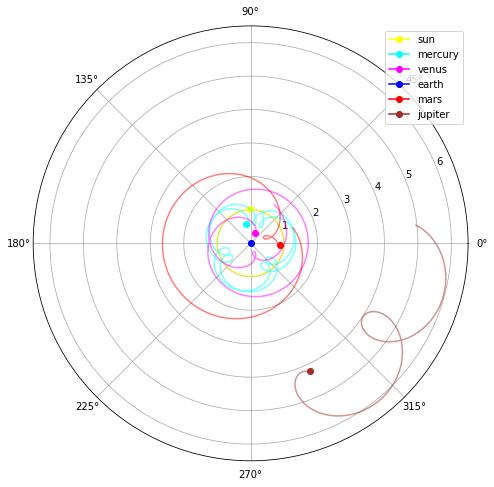

In [26]:
plt.figure(figsize=(8,8))

names = ['sun','mercury','venus','earth', 'mars','jupiter']
for name in names:
    
    # Starting point
    plt.polar(coords[name]['theta_geo'].rad[0],
              coords[name]['r_geo'][0].value, 
              marker='o', color=coords[name]['color'], label=name)
    
    # Track
    plt.polar(coords[name]['theta_geo'].rad[twoyear],
              coords[name]['r_geo'][twoyear].value,
              alpha=0.5,color=coords[name]['color'])


ax=plt.gca()
ax.set_rlim(0,6.5)
plt.legend()
plt.show()

NameError: name 'rlim' is not defined

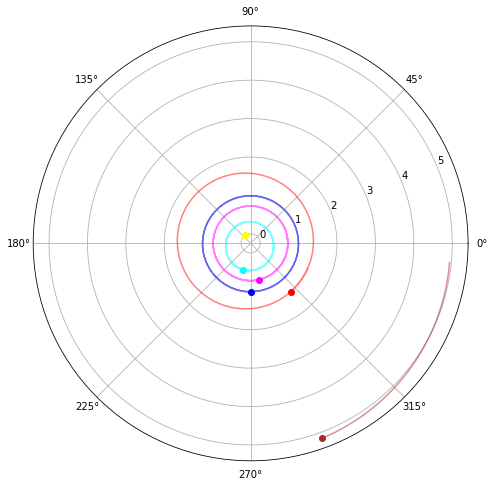

In [86]:
plt.figure(figsize=(8,8))

names = ['sun','mercury','venus','earth', 'mars','jupiter']
for name in names:
    
    # Starting point
    plt.polar(coords[name]['theta_hel'].rad[0],
              coords[name]['r_hel'][0].value, 
              marker='o', color=coords[name]['color'], label=name)
    
    # Track
    plt.polar(coords[name]['theta_hel'].rad[twoyear],
              coords[name]['r_hel'][twoyear].value,
              alpha=0.5,color=coords[name]['color'])

ax=plt.gca()
ax.set_rlim(0,rlim) 
    
plt.legend()
plt.show()

In [73]:
def Orrery(i, dirname = '', heliocentric=True, rlim=6.5):
    
    
    if heliocentric:
        theta = 'theta_hel'
        r = 'r_hel'
    else:
        theta = 'theta_geo'
        r = 'r_geo'

    plt.figure(figsize=(8,8))

    names = ['sun','mercury','venus','earth', 'mars','jupiter']
    for name in names:
    
    # Current location
        plt.polar(coords[name][theta].rad[i],
                  coords[name][r][i].value, 
                  marker='o', color=coords[name]['color'], label=name)
    
    # Track till now
        start_track = 0 #np.max([0,i-300])
        plt.polar(coords[name][theta].rad[start_track:i],
                  coords[name][r][start_track:i].value,
                  alpha=0.5,color=coords[name]['color'])

    ax=plt.gca()
    ax.set_rlim(0,rlim) 
        
    plt.legend(loc='upper right')
    plt.savefig(dirname+'/orrery'+str(i).zfill(4)+'.png')
    plt.close()

In [71]:
def MovieFromFileDir(filedir, movie_filename, fps=20):
    
    files = glob(filedir+'/orrery????.png')
    files.sort()
    
    # Read the initial frame to get the size
    img = cv2.imread(files[0])
    height, width, layers = img.shape
    size = (width,height)
    
    out = cv2.VideoWriter(movie_filename, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for fn in files:

        img = cv2.imread(fn)
        out.write(img)

    out.release()
    
    return

In [82]:
%%time
timer = Timer()
timer.start()
indx = np.arange(0,len(times),3)
ntimes = np.max(indx)
for i in indx:
    ProgressBar(i/ntimes)
    Orrery(i, heliocentric=True, dirname='orrery_heliocen', rlim=5.5)
timer.stop('Took ')

Progress: [####################] 100.0%
Took  237.95181488990784 sec
CPU times: user 3min 35s, sys: 14.1 s, total: 3min 49s
Wall time: 3min 57s


In [83]:
%%time
MovieFromFileDir('orrery_heliocen', 'orrery_heliocen.mp4')

CPU times: user 6.36 s, sys: 195 ms, total: 6.55 s
Wall time: 6.57 s


In [28]:
%%time
timer = Timer()
timer.start()
ntimes = len(twoyear)
for i in range(ntimes):
    ProgressBar(i/ntimes)
    Orrery(i, heliocentric=False, dirname='orrery_geocen')
timer.stop('Took ')

Progress: [####################] 99.9%
Took  114.87284088134766 sec
CPU times: user 1min 50s, sys: 3.39 s, total: 1min 53s
Wall time: 1min 54s


In [68]:
%%time
MovieFromFileDir('orrery_geocen', 'orrery_geocen.mp4')